1. [No of fights, avg duration of fight](#basic_eda)
2. [Fighters by country](#countries)
3. [Weights division EDA](#divisions)
    * [Men vs womens fights](#male_female)
    * [Fights per division](#fights_p_d)
    * [Average duration of fight](#avg_dur)
    * [KO/TKO submissions time](#KO_TKO)
    * [Effect of ground cotrol and signifficant strikes](#ground_sig_s)
4. [Building of model](#model)
    * [Fighter skills](#skills)
    * [Logistic regression](#reg)
    * [Support Vector Machines](#svc)
5. [Head2Head ](#h2h)  

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
fights_df = pd.read_csv('../input/mma-differentials-and-elo/masterdataframe.csv', parse_dates=True)
fighters_df= pd.read_csv('../input/pro-mma-fighters/pro_mma_fighters.csv')
coordinates =  pd.read_csv('../input/countries/countries.csv')

In [30]:
ufc_fighters = pd.DataFrame(fights_df.drop_duplicates("fighter")["fighter"])
ufc_fighters.shape

(2261, 1)

In [31]:
print(f"From {fights_df.date.min()} to {fights_df.date.max()} there were {len(fights_df)//2} fights in total, included {ufc_fighters.shape[0]} fighters")

From 1994-03-11 to 2022-06-25 there were 6661 fights in total, included 2261 fighters


In [32]:
fights_df = fights_df.loc[:,:"ground_strikes_def_differential"]
fights_df["year"] = pd.DatetimeIndex(fights_df['date']).year

<a id="basic_eda"></a>
# Fights per year

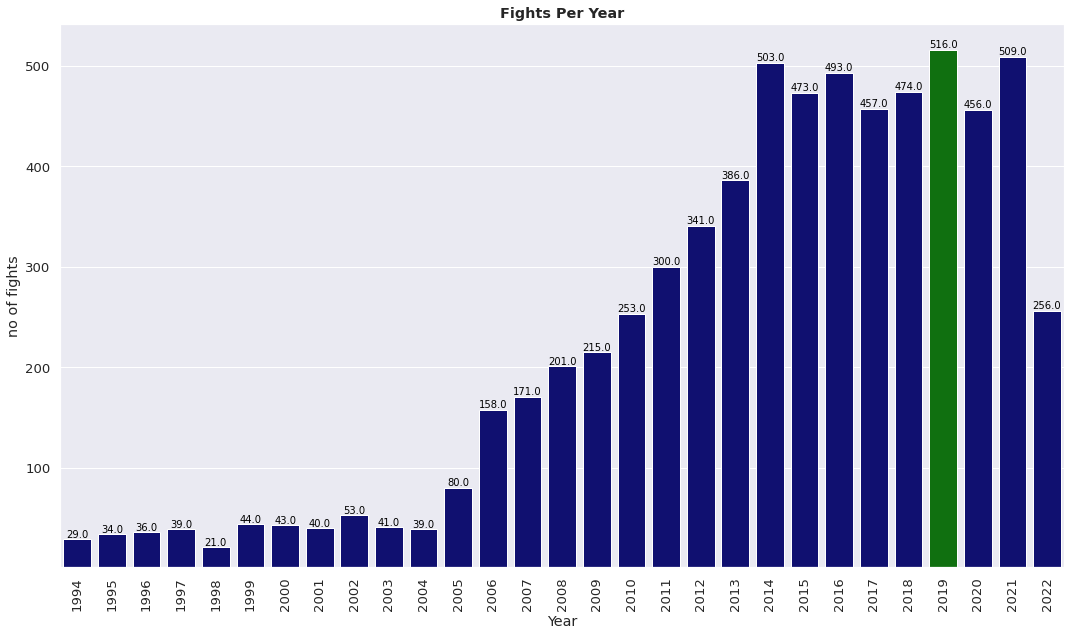

In [33]:
fights_by_year = pd.DataFrame(fights_df.groupby("year")["result"].count()//2).rename(columns ={"result":"no of fights"})
values = fights_by_year["no of fights"]
colors = ['navy' if (y < max(values)) else 'green' for y in values ]
sns.set(font_scale = 1.2)
plt.figure(figsize=(18,10))
bar = sns.barplot(x=fights_by_year.index, y=values, palette=colors)

ax = plt.gca()
y_max = values.max() 
ax.set_ylim(1)
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), p.get_height(), 
        fontsize=10, color='black', ha='center', va='bottom')
    
plt.xlabel('Year')
plt.xticks(rotation = 90) 
plt.ylabel('no of fights')
plt.title('Fights Per Year',weight='bold')
plt.show()

In [34]:
replace_map = {
    "M-DEC": "DEC",
    "S-DEC" : "DEC",
    "U-DEC": "DEC",
    "DRAW": "DEC"

}
df1=fights_df.copy()
df1["method"] = df1["method"].replace(replace_map)

df1 = df1.groupby("year")["method"].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

**Duration of the match vs the method of ending**

We can see that in early years was average time of fight lower as more fights were ended by KO/TKO or submission. Through the time average time decrease with fact that more fights goes to the decision

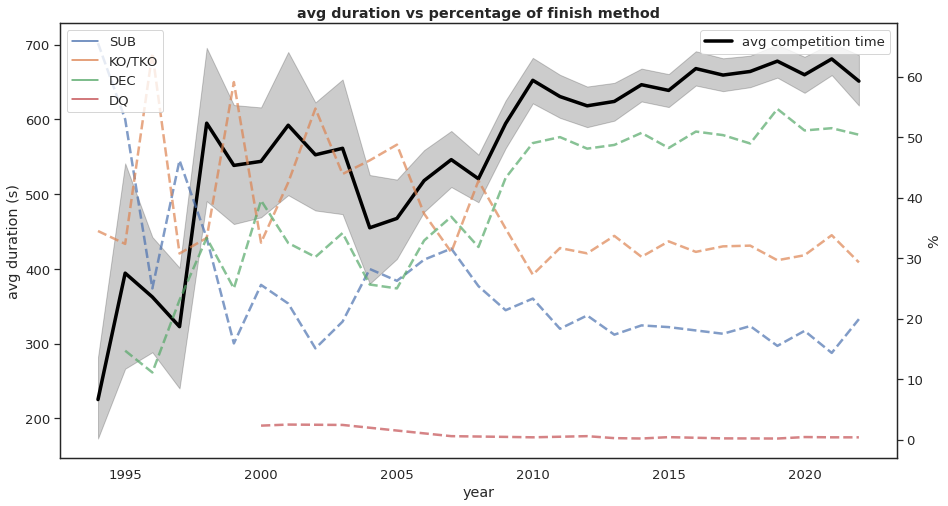

In [35]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(15,8))
g = sns.lineplot(x="year", y="total_comp_time", data= fights_df, color='black', ax=ax,linewidth = 3.5, label = "avg competition time" )
ax1=ax.twinx()
g1 = sns.lineplot(x="year",y='percent', hue ="method",data=df1,  markers=True, dashes=False, linewidth = 2.5, ax=ax1,alpha=0.7,linestyle='--')
g.set_title("avg duration vs percentage of finish method",weight='bold')
ax1.legend(loc="upper left")
ax.set(ylabel='avg duration (s)')
ax1.set(ylabel='%')
plt.xticks(rotation=90)
plt.show()

<a id="countries"></a>
# Fighters by country


Let's see on the map where ufc fighters come from

In [36]:
ufc_fighters = ufc_fighters.merge(fighters_df[["fighter_name", "country"]], left_on="fighter", right_on= "fighter_name", how='left').drop(columns = ['fighter_name'])

In [37]:
fighters_with_geo = ufc_fighters.merge(coordinates, left_on='country', right_on='COUNTRY', how='left').drop(columns = ['ISO', 'COUNTRY','COUNTRYAFF', 'AFF_ISO'])
fighters_with_geo=fighters_with_geo.dropna()

In [38]:
# Create a world map to show distributions of users 
import folium
from folium.plugins import MarkerCluster
#empty map
world_map= folium.Map(tiles="cartodbpositron")
marker_cluster = MarkerCluster().add_to(world_map)
#for each coordinate, create circlemarker of user percent
for i in range(len(fighters_with_geo)):
        lat = fighters_with_geo.iloc[i]['latitude']
        long = fighters_with_geo.iloc[i]['longitude']
        radius=5
        popup_text = """Country : {}<br>
                    fighter : {}<br>"""
        popup_text = popup_text.format(fighters_with_geo.iloc[i]['country'],
                                   fighters_with_geo.iloc[i]['fighter']
                                   )
        folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)
#show the map
world_map

In [39]:
fights_df.division.value_counts(normalize = True)

Lightweight              0.177301
Welterweight             0.174448
Middleweight             0.134664
Heavyweight              0.095031
Featherweight            0.093980
Light Heavyweight        0.091728
Bantamweight             0.082420
Flyweight                0.039333
Women's Strawweight      0.035280
Women's Bantamweight     0.025372
Women's Flyweight        0.024771
Open Weight              0.015313
Catch Weight             0.006756
Women's Featherweight    0.003453
Super Heavyweight        0.000150
Name: division, dtype: float64

<a id="divisions"></a>
# Weight divisions EDA

<a id="male_female"></a>
 **men vs women fights**

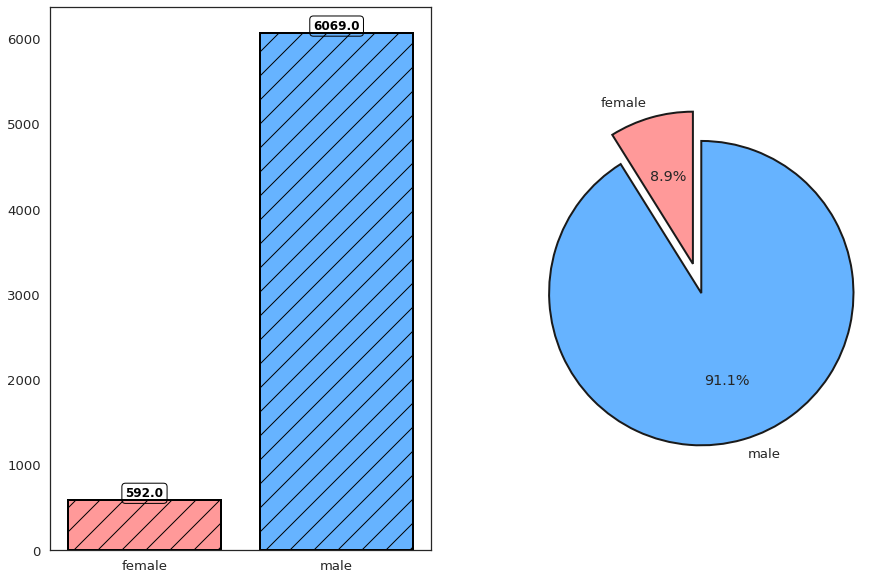

In [40]:
fights_df["gender"] = fights_df.division.apply(lambda x: "female" if x[0:3]=="Wom" else "male")

labels = "female", "male"
fig1, ax1 = plt.subplots(1,2, figsize=(15,10))
ax1[1].pie(fights_df.groupby(["gender"])["gender"].count()/2,explode=(0.1, 0.1), autopct='%1.1f%%', labels= labels,
        startangle=90,colors=['#ff9999','#66b3ff'],wedgeprops={'linewidth': 2, 'edgecolor': 'k'},labeldistance=1.1)

ax1[0].bar(("female", "male"), fights_df.groupby(["gender"])["gender"].count()/2, color=['#ff9999','#66b3ff'],edgecolor="black", hatch='/',linewidth=2)
for p in ax1[0].patches:
    ax1[0].text(p.get_x() + p.get_width()/2., p.get_height(), p.get_height(), 
        fontsize=12, color='black', ha='center', va='bottom', weight='bold',bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=1))
plt.show()

Let's remove divisions with small amount of fights

In [41]:
fights_df = fights_df[fights_df.gender!="female"]
fights_df = fights_df[~fights_df["division"].isin(["Open Weight", "Catch Weight", "Super Heavyweight"])]
weights=["Flyweight", "Bantamweight", "Featherweight", "Lightweight", "Welterweight", "Middleweight", "Light Heavyweight", "Heavyweight"] 

<a id="fights_p_d"></a>
**Fights per division**

In [42]:
import numpy as np
pivot = fights_df.pivot_table(values="result", index="division", columns="method", aggfunc="count", fill_value = 0).apply(lambda x: x//2)
pivot["total_fights"] = pivot.iloc[:,0:7].sum(axis=1)
pivot

method,DQ,DRAW,KO/TKO,M-DEC,S-DEC,SUB,U-DEC,total_fights
division,,,,,,,,
Bantamweight,1,15,156,3,68,114,192,549
Featherweight,1,14,165,4,64,101,277,626
Flyweight,0,4,59,0,34,50,115,262
Heavyweight,3,12,341,9,28,96,144,633
Light Heavyweight,3,15,266,6,43,104,174,611
Lightweight,2,21,329,10,119,271,429,1181
Middleweight,4,11,333,3,77,199,270,897
Welterweight,5,17,377,10,112,216,425,1162


In [43]:
time_by_division = pd.DataFrame(fights_df.groupby("division")["total_comp_time"].sum()//2)

pivot = pivot.join(time_by_division) 
pivot["sub/time"] = pivot["total_comp_time"]//pivot["SUB"]
pivot["KO/TKO_time"] = pivot["total_comp_time"]//pivot["KO/TKO"]

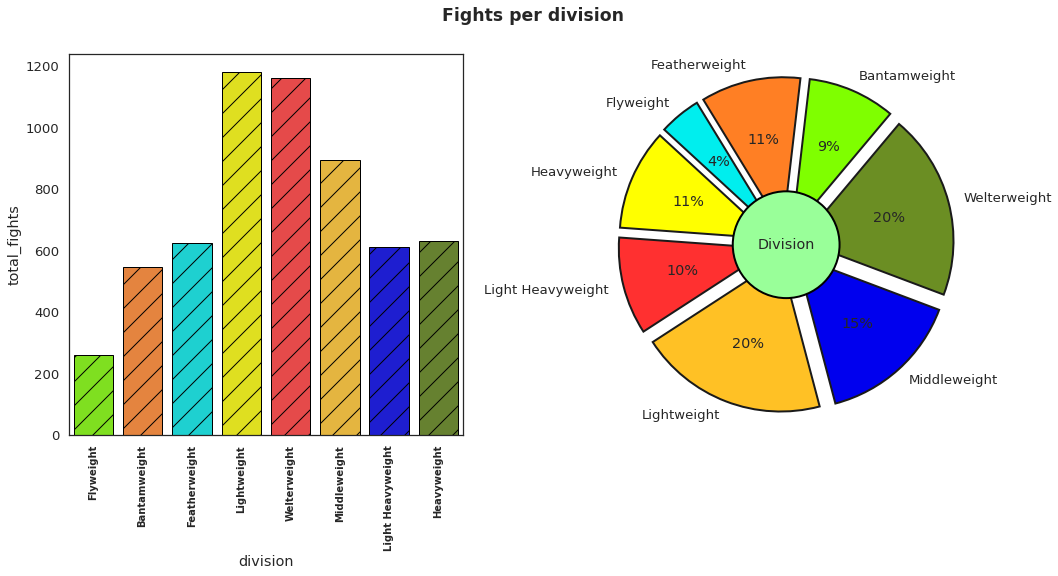

In [44]:
colors = ['#7FFF00', '#FF7F24', '#00EEEE', '#FFFF00', '#FF3030', '#FFC125', '#0000EE', '#6B8E23']
fig, ax=plt.subplots(1, 2, figsize=(15,8))
g=sns.barplot(x=pivot.index,y="total_fights",  data= pivot, order = weights, ax =ax[0], palette = colors, edgecolor="black",hatch='/')
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 90, size = 10, weight='bold')
x=0
y=0

ax[1].pie(x= pivot["total_fights"], labels = pivot.index, colors = colors, autopct='%.0f%%',
            explode=[0.1 for i in pivot.index], startangle=50,
            wedgeprops={'linewidth': 2, 'edgecolor': 'k'},labeldistance=1.1)
ax[1].add_artist(plt.Circle((0, 0), 0.35, fc='#99ff99', ec='black', lw=2))
ax[1].annotate("Division", xy=(x, y),va="center",  ha="center")
fig.suptitle("Fights per division", y=1, weight = 'bold')
plt.tight_layout(pad=1, w_pad=1, h_pad=1)
plt.show()

In [45]:
fights_df["opponent_control"] = fights_df["control"]/fights_df["control_differential"]
fights_df["total_control"] = fights_df["control"] + fights_df["opponent_control"]
fights_df["clear_time_on_feet"] = fights_df["total_comp_time"] - fights_df["total_control"]
fights_df["strikes_per_min_standup"] =(fights_df["total_strikes_attempts"]/fights_df["clear_time_on_feet"])*60

gr_by_fights=fights_df.groupby("fight_url")[["control","total_comp_time", "division"]].agg({"control": "sum", "total_comp_time":"sum", "division": "first"})
gr_by_fights["total_comp_time"] = gr_by_fights["total_comp_time"].apply(lambda x: x//2)
gr_by_fights["standup_time"] = gr_by_fights["total_comp_time"]-gr_by_fights["control"]

gr_by_fights = gr_by_fights[["division", "standup_time", "control"]]
gr_by_fights_melted = pd.melt(gr_by_fights, id_vars=["division"], value_vars =['standup_time', 'control'])

<a id="avg_dur"></a>
**What is the average duration of fight for each division and how it is split ground game with stand-up fight?**

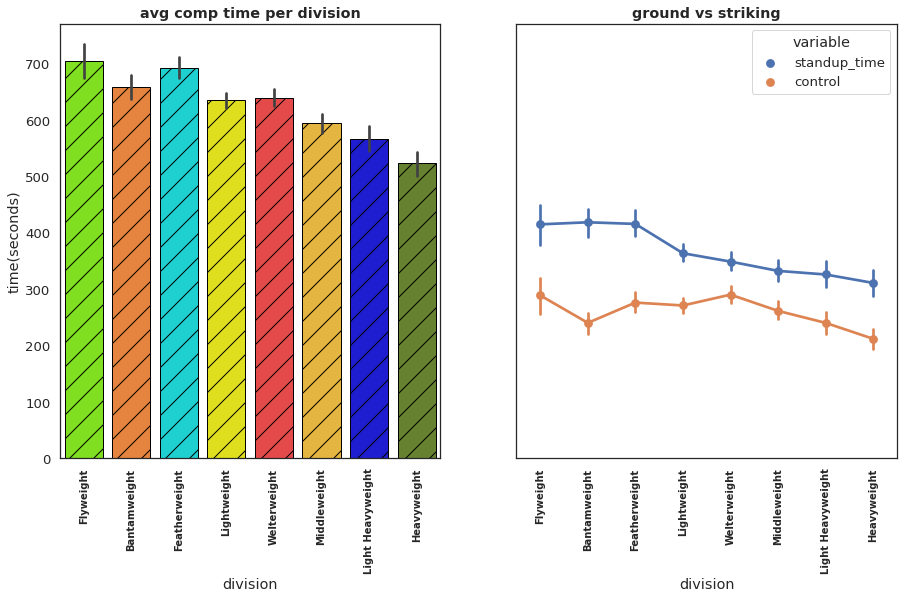

In [46]:
fig, axes = plt.subplots(1, 2, sharey = True, figsize=(15,8))
g=sns.barplot(x="division", y ="total_comp_time", data = fights_df, order=weights, ax=axes[0], palette = colors,edgecolor="black",hatch='/')
g1=sns.pointplot(data = gr_by_fights_melted, x="division", y="value", hue = "variable", order = weights, ax=axes[1])
axes[0].set_ylabel("time(seconds)")
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation = 90, size = 10, weight='bold')
axes[0].set_title('avg comp time per division',weight='bold')
axes[1].set_ylabel("")
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation = 90, size = 10, weight='bold')
axes[1].set_title('ground vs striking',weight='bold')
plt.show()

<a id="KO_TKO"></a>
**How many seconds are needed for KO or Submission?**

 We can see that time for KO/TKO positive correlate with average duration of fight.

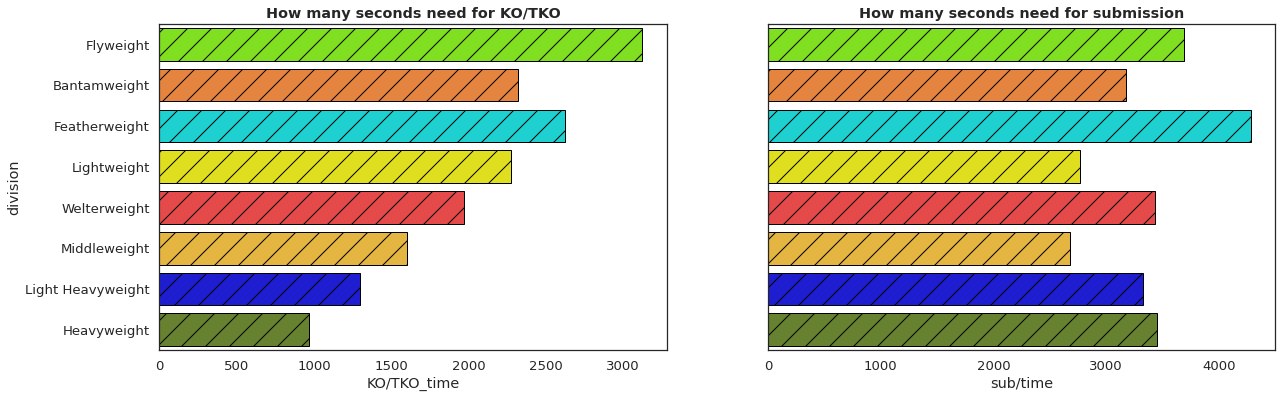

In [47]:
fig, axes = plt.subplots(1, 2, sharey=True,figsize=(20,6))
g=sns.barplot(y=pivot.index, x="KO/TKO_time", data=pivot, order=weights,ax=axes[0],palette = colors, edgecolor="black",hatch='/')
g1=sns.barplot(y=pivot.index, x="sub/time", data=pivot, order=weights, ax=axes[1],palette = colors, edgecolor="black",hatch='/')
axes[0].set_title('How many seconds need for KO/TKO',weight='bold')
axes[1].set_title('How many seconds need for submission',weight='bold')
g1.set_ylabel('')
plt.show()

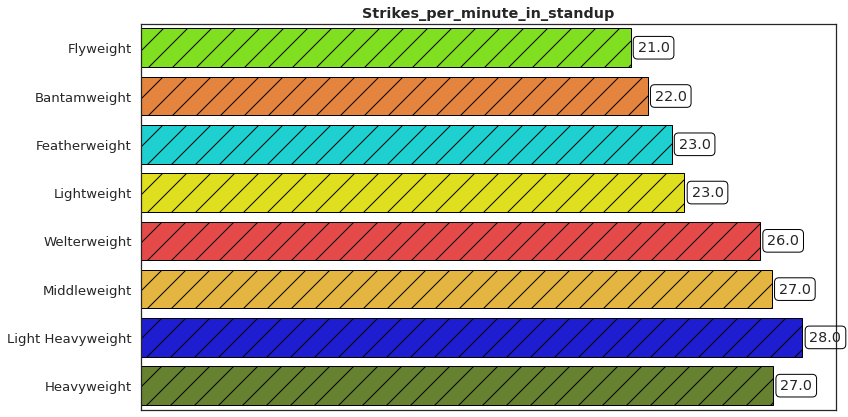

In [48]:
plt.figure(figsize=(12,6))
g = sns.barplot(x="strikes_per_min_standup",y="division", data=fights_df,order = weights,edgecolor="black",palette = colors, hatch='/', ci= None)
g.set(xticklabels=[])
plt.xticks(rotation=90)
g.set(ylabel=None, xlabel=None)
g.set_title('Strikes_per_minute_in_standup',weight='bold')
for p in g.patches:
    value = round(p.get_width(),0)
    x = p.get_x() + p.get_width() +0.3
    y = p.get_y() + p.get_height() / 2 
    g.text(x, y, value, ha='left', va='center', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=1))

plt.tight_layout(pad=1, w_pad=1, h_pad=1)
plt.show()

<a id="ground_sig_s"></a>
**How difference in ground control and significant strikes affect a result of a match.**

if Fighter1 have ground control 300s and Fighter2 100s -> control_diff Fighter1 = 200s ; control_diff Fighter2 = -200s. Same logic with significant strikes landed

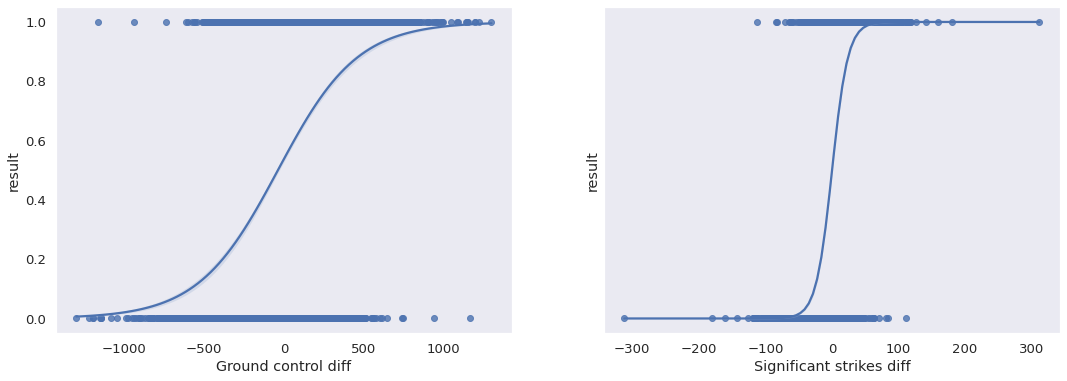

In [49]:
fights_df["opponent_sig_strikes"] = fights_df["sig_strikes_landed"]/fights_df["sig_strikes_landed_differential"]
fights_df["control_diff"] = fights_df["control"]  - fights_df["opponent_control"] 
fights_df["sig_strike_diff_s"] = fights_df["sig_strikes_landed"]  - fights_df["opponent_sig_strikes"] 

sns.set_style("dark")
fig, axes = plt.subplots(1, 2, sharey=True,figsize=(18,6))
g=sns.regplot(x="control_diff", y="result", data = fights_df, logistic=True,ax = axes[0])
g.set( xlabel ="Ground control diff")
g1=sns.regplot(x="sig_strike_diff_s", y="result", data = fights_df, logistic=True,ax = axes[1])
g1.set( xlabel ="Significant strikes diff")
plt.show()

<Figure size 864x432 with 0 Axes>

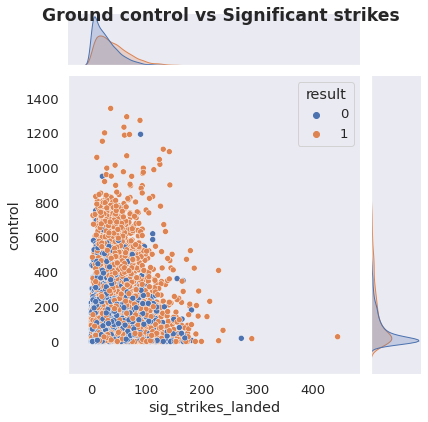

In [50]:
plt.figure(figsize=(12,6))
g = sns.jointplot(data=fights_df, x="sig_strikes_landed", y="control", hue="result")
plt.suptitle('Ground control vs Significant strikes', weight='bold')
plt.show()

<a id="model"></a>
# Building of model

In [51]:
ufc_fighters = ufc_fighters.drop("country", axis=1)
ufc_fighters["no_of_matches"] = ufc_fighters.fighter.map(fights_df.fighter.value_counts())
ufc_fighters=ufc_fighters.drop_duplicates("fighter")
ufc_fighters = ufc_fighters.set_index("fighter")
fighters_to_analyze = pd.DataFrame(ufc_fighters.index[ufc_fighters["no_of_matches"]>3])

<a id="skills"></a>
**Lets define some skills needed for prediction and head to head comparsion**

In [52]:
def skills(fighter_name):

  time_total = fights_df["total_comp_time"][(fights_df["fighter"]==fighter_name)].sum()
  time_ground_control = fights_df["control"][(fights_df["fighter"]==fighter_name)].sum()
  no_of_fights= ufc_fighters.loc[fighter_name]["no_of_matches"]
  time_standup = time_total - fights_df["control"][(fights_df["fighter"]==fighter_name)].sum()

  def ground_skills_def():    
    sub_losses = fights_df["result"][(fights_df["fighter"]==fighter_name) & (fights_df["result"]==0) & (fights_df["method"]=="SUB")].count()
    sub_losses_ratio = sub_losses/no_of_fights    

    ground_op_control = fights_df["opponent_control"][(fights_df["fighter"]==fighter_name)].sum()
    op_control_ratio = ground_op_control/time_total
    
    g_a_p_deff = g_a_p = fights_df["ground_strikes_def"][(fights_df["fighter"]==fighter_name)].mean()/100
    takedown_def = fights_df["takedowns_def"][fights_df["fighter"]==fighter_name].mean()/100
    reversal_skill = (fights_df["reversals"][fights_df["fighter"]==fighter_name].sum()/no_of_fights)
    skill_total = (takedown_def+ reversal_skill - (sub_losses_ratio*2)+g_a_p_deff)*(1-op_control_ratio)
    return skill_total if skill_total > 0 else 0
    

  def ground_skills_att():    
    sub_winner = fights_df["result"][(fights_df["fighter"]==fighter_name) & (fights_df["result"]==1) & (fights_df["method"]=="SUB")].count()
    sub_winner_ratio = sub_winner/no_of_fights   
    ground_control_coef = (1-(time_ground_control/time_total))

    g_a_p = fights_df["ground_strikes_landed"][(fights_df["fighter"]==fighter_name)].sum()/time_total
    takedown_att = fights_df[fights_df["fighter"]==fighter_name]["takedowns_accuracy"].mean()/100

    skill_total = (takedown_att+ g_a_p + (sub_winner_ratio*2))/ground_control_coef    
    return (skill_total)

  def standing_skills_att():
    
    ko_wins = fights_df["result"][(fights_df["fighter"]==fighter_name) & (fights_df["result"]==1) & (fights_df["method"]=="KO/TKO")].count()
    ko_wins_ratio = ko_wins/no_of_fights   
    standup_ratio = time_standup/time_total
    ground_strikes = fights_df["ground_strikes_attempts"][fights_df["fighter"]==fighter_name].sum()

    sig_strikes_eff = (fights_df["sig_strikes_landed"][(fights_df["fighter"]==fighter_name)].sum()-ground_strikes)/time_standup
    hand_speed =(fights_df[fights_df["fighter"]==fighter_name]["total_strikes_attempts"].sum() - ground_strikes)/time_standup
    clinch = fights_df[fights_df["fighter"]==fighter_name]["clinch_strikes_landed"].sum()/time_standup/fights_df[fights_df["fighter"]==fighter_name]["clinch_strikes_accuracy"].mean()/100
    accuracy = (fights_df[fights_df["fighter"]==fighter_name]["total_strikes_accuracy"].mean() + fights_df[fights_df["fighter"]==fighter_name]["distance_strikes_accuracy"].mean())/200
    total_skill = (clinch+(ko_wins_ratio*2) + (sig_strikes_eff+hand_speed+accuracy)/2)    
    return (total_skill)

  def standing_skills_def():
    
    ko_losses = fights_df["result"][(fights_df["fighter"]==fighter_name) & (fights_df["result"]==0) & (fights_df["method"]=="KO/TKO")].count()
    ko_losses_ratio = ko_losses/no_of_fights      
    
    standup_ratio = time_standup/time_total    

    sig_strikes_def = fights_df["sig_strikes_def"][(fights_df["fighter"]==fighter_name)].mean()/100
    clinch_strikes_def =fights_df[fights_df["fighter"]==fighter_name]["clinch_strikes_def"].mean()/100     
    distance_strikes_def = fights_df[fights_df["fighter"]==fighter_name]["distance_strikes_def"].mean()/100    
    total_skill = (clinch_strikes_def-ko_losses_ratio*2 + sig_strikes_def+distance_strikes_def)*standup_ratio
    
    return total_skill if total_skill > 0 else 0
  
  def stamina():
    wins_second_round= fights_df["result"][(fights_df["fighter"]==fighter_name) & (fights_df["total_comp_time"]>300)& (fights_df["total_comp_time"]<=600)].sum()
    wins_third_round= fights_df["result"][(fights_df["fighter"]==fighter_name) & (fights_df["total_comp_time"]>600)& (fights_df["total_comp_time"]<=900)].sum()
    wins_champ_round= fights_df["result"][(fights_df["fighter"]==fighter_name) & (fights_df["total_comp_time"]>900)].sum()

    fights_second_round= fights_df["result"][(fights_df["fighter"]==fighter_name) & (fights_df["total_comp_time"]>300)& (fights_df["total_comp_time"]<=600)].count()
    fights_third_round= fights_df["result"][(fights_df["fighter"]==fighter_name) & (fights_df["total_comp_time"]>600)& (fights_df["total_comp_time"]<=900)].count()
    fights_champ_round= fights_df["result"][(fights_df["fighter"]==fighter_name) & (fights_df["total_comp_time"]>900)].count()

    fights_second_round = fights_second_round if fights_second_round >0 else 1
    fights_third_round = fights_third_round if fights_third_round >0 else 1
    fights_champ_round = fights_champ_round if fights_champ_round >0 else 1
   
    total_skill = np.array([(0.2*wins_second_round/fights_second_round),(0.6*wins_third_round/fights_third_round),(wins_champ_round/fights_champ_round)])
    return total_skill.sum()
    
  return (ground_skills_def(),ground_skills_att(),standing_skills_def(), standing_skills_att() ,stamina())

In [53]:
def form(fighter_name, datum):
  vysledek=''
  skore = 0
  koef =0.1
  result = ['W' if x==1 else 'L' for x in fights_df['result'][(fights_df['fighter']==fighter_name) & (fights_df['date']<datum)]]
  for vyhra in result[:-6:-1]:
    if vyhra =='W':
      skore+=koef
    else:
      skore-=koef
    koef+=0.1  
    vysledek +=vyhra+' '
  vysledek=vysledek[:-1]  
  return (vysledek,skore)

In [54]:
fighters_to_analyze.isna().sum()
fighters_to_analyze[["ground_def_skill","ground_att_skill", "stand_def_skill","stand_att_skill", "stamina"]] = fighters_to_analyze["fighter"].apply(skills).apply(pd.Series).astype(float)
fighters_to_analyze["stand_att_skill"] = fighters_to_analyze['stand_att_skill'].fillna(0)

In [55]:
fights_to_analyze = fights_df[["date", "fighter","opponent","result","method"]]

fights_to_analyze.loc[:,"form_skore_fighter"] = fights_to_analyze.apply(lambda x:form(x.fighter, x.date)[1], axis=1).astype(float)
fights_to_analyze.loc[:,"form_skore_opponent"] = fights_to_analyze.apply(lambda x:form(x.opponent, x.date)[1], axis=1).astype(float)

fights_to_analyze = fights_to_analyze.merge(fighters_to_analyze, on="fighter", how="inner")
fights_to_analyze = fights_to_analyze.merge(fighters_to_analyze,left_on="opponent",right_on="fighter", how="inner", suffixes=("_fighter","_opponent"))
fights_to_analyze=fights_to_analyze.drop("fighter_opponent",axis=1)
fights_to_analyze.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,date,fighter_fighter,opponent,result,method,form_skore_fighter,form_skore_opponent,ground_def_skill_fighter,ground_att_skill_fighter,stand_def_skill_fighter,stand_att_skill_fighter,stamina_fighter,ground_def_skill_opponent,ground_att_skill_opponent,stand_def_skill_opponent,stand_att_skill_opponent,stamina_opponent
0,1998-03-13,Jerry Bohlander,Kevin Jackson,1,SUB,0.3,0.4,1.204018,2.001237,1.810119,0.212740,0.3,0.750000,1.523377,2.238971,0.000000,0.000000
1,1997-07-27,Tony Fryklund,Kevin Jackson,0,SUB,0.0,0.0,0.342785,1.868140,1.014574,0.828202,0.2,0.750000,1.523377,2.238971,0.000000,0.000000
2,1997-12-21,Frank Shamrock,Kevin Jackson,1,SUB,0.0,0.3,1.238585,1.415141,2.367848,1.230637,1.2,0.750000,1.523377,2.238971,0.000000,0.000000
3,1999-01-08,Jerry Bohlander,Tito Ortiz,0,KO/TKO,0.6,0.1,1.204018,2.001237,1.810119,0.212740,0.3,1.305347,1.143868,0.990854,0.928138,0.839394
4,2005-02-05,Vitor Belfort,Tito Ortiz,0,S-DEC,0.5,0.5,1.025646,0.296940,1.218947,1.165237,0.2,1.305347,1.143868,0.990854,0.928138,0.839394


<a id="reg"></a>
**Regression**

In [56]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,plot_confusion_matrix
X =fights_to_analyze[["ground_def_skill_fighter","ground_att_skill_fighter","stand_att_skill_fighter","stand_def_skill_fighter","stamina_fighter","form_skore_fighter",
                      "ground_def_skill_opponent", "ground_att_skill_opponent", "stand_att_skill_opponent","stand_def_skill_opponent","stamina_opponent", "form_skore_opponent" ]]
y = fights_to_analyze["result"]

xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=21)

Training Accuracy    : 70.99 %
Model Accuracy Score : 70.01 %


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


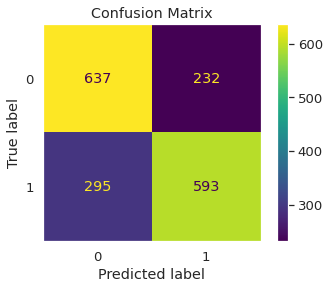

In [57]:
reg = LogisticRegression()
reg.fit(xtrain, ytrain)

y_pred_lr = reg.predict(xtest)
log_train = round(reg.score(xtrain, ytrain) * 100, 2)
log_accuracy_MinMax = round(accuracy_score(y_pred_lr, ytest) * 100, 2)

print("Training Accuracy    :",log_train ,"%")
print("Model Accuracy Score :",log_accuracy_MinMax ,"%")
plot_confusion_matrix(reg, xtest, ytest);
plt.title('Confusion Matrix');

<a id="svc"></a>
**Support Vector Machines**

Training Accuracy    : 74.12 %
Model Accuracy Score : 71.66 %


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


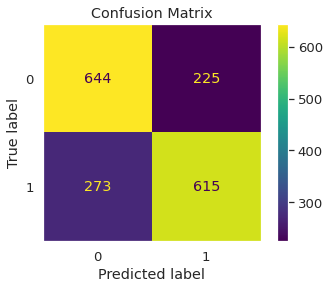

In [58]:
from sklearn.svm import SVC
svc = SVC(probability=True)
svc.fit(xtrain, ytrain)
y_pred_svc = svc.predict(xtest)

svc_train = round(svc.score(xtrain, ytrain) * 100, 2)
svc_accuracy = round(accuracy_score(y_pred_svc, ytest) * 100, 2)

print("Training Accuracy    :",svc_train ,"%")
print("Model Accuracy Score :",svc_accuracy ,"%")
plot_confusion_matrix(svc, xtest, ytest);
plt.title('Confusion Matrix');

<a id="h2h"></a>
# Head2Head

normalizing skills to get 0-100 range of each skill, just for better comparsion

In [59]:
from sklearn import preprocessing
fighters_normalized = fighters_to_analyze.copy()
fighters_normalized.iloc[:,1:] =  preprocessing.normalize(fighters_normalized.iloc[:,1:])
fighters_normalized.iloc[:,1:]=fighters_normalized.iloc[:,1:].apply(lambda x:round(x*100,0)) 
fighters_normalized = fighters_normalized.set_index('fighter')
fighters_normalized.describe()

,ground_def_skill,ground_att_skill,stand_def_skill,stand_att_skill,stamina
count,1083.000000,1083.000000,1083.000000,1083.000000,1083.000000
mean,52.866113,32.473684,53.815328,34.800554,21.348107
std,17.007490,22.815462,18.513548,15.424640,14.077543
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44.000000,15.000000,42.000000,22.000000,12.000000
50%,55.000000,28.000000,56.000000,34.000000,20.000000
75%,64.000000,49.000000,66.000000,45.000000,28.000000
max,96.000000,97.000000,96.000000,87.000000,71.000000


In [60]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from math import pi

def proba(fighter,opponent):
  form_fighter = form(fighter,"2022-12-12")
  form_opponent = form(opponent,"2022-12-12")
  h1 =  fighters_to_analyze[fighters_to_analyze.fighter==fighter].copy()
  h1.loc[:,'form_skore'] = form_fighter[1]
  h2=fighters_to_analyze[fighters_to_analyze.fighter==opponent].copy()
  h2.loc[:,'form_skore'] = form_opponent[1]
  h1.loc[:,"opponent"] = opponent
  h1=h1.merge(h2, left_on="opponent", right_on="fighter", how="inner",suffixes=("_fighter","_opponent"))
  h1=h1.loc[:,["ground_def_skill_fighter","ground_att_skill_fighter","stand_att_skill_fighter","stand_def_skill_fighter","stamina_fighter","form_skore_fighter",
                      "ground_def_skill_opponent", "ground_att_skill_opponent", "stand_att_skill_opponent","stand_def_skill_opponent","stamina_opponent", "form_skore_opponent"]]  
  
  probs = svc.predict_proba(h1)
  prob_fighter = probs[0][1]
  prob_opponent = probs[0][0]  
  return prob_fighter,prob_opponent



def Head2Head(fighter,opponent):
  moje_prob = proba(fighter,opponent)
  form_fighter = form(fighter,"2022-12-12")
  form_opponent = form(opponent,"2022-12-12")
  prob_fighter = moje_prob[0]
  prob_opponent = moje_prob[1]

  fig = plt.figure(figsize=(19,10))
  ax1 = fig.add_subplot(2,3,1)
  a=mpimg.imread('../input/pictures/' + fighter +'.png')
  ax1.imshow(a)
  plt.axis('off')
  ax2 = fig.add_subplot(2,3,3)
  a=mpimg.imread('../input/pictures/'+opponent+'.png')
  ax2.imshow(a)
  plt.axis('off')
  
  x=0
  y=0
  ax3 = fig.add_subplot(2,3,2)
  ax3.pie(x= (prob_fighter,prob_opponent), labels = (fighter,opponent), colors = ["#EE2C2C","#6495ED"], autopct='%.00f%%',
              startangle=90,
              wedgeprops={'linewidth': 2, 'edgecolor': 'k'},labeldistance=1.1,textprops={'fontsize': 14, 'weight': 'bold'})
  ax3.add_artist(plt.Circle((0, 0), 0.35, fc='white', ec='black', lw=2))
  ax3.annotate("% to win", xy=(x, y),va="center",  ha="center")
  plt.tight_layout(pad=1, w_pad=1, h_pad=1)

  #  skills plot
  #----------------------------------------------------------------------
  from matplotlib import rcParams
  rcParams['xtick.major.pad']='15'
  ax4 = fig.add_subplot(2,3,5, polar =True)  
  categories=list(fighters_normalized)
  N = len(categories)  
  
  angles = [n / float(N) * 2 * pi for n in range(N)]
  angles += angles[:1]
    
  # If you want the first axis to be on top:
  ax4.set_theta_offset(pi / 2)
  ax4.set_theta_direction(-1)
  
  # Draw one axe per variable + add labels
  plt.xticks(angles[:-1], categories,fontsize=10)

  # Draw ylabels
  ax4.set_rlabel_position(0)
  plt.yticks([x*10 for x in range(8)], [str(x*10) for x in range(8)], color="grey", size=10)
  plt.ylim(0,80)
  
  # ------- PART 2: Add plots
  
  # Plot each individual = each line of the data
  # I don't make a loop, because plotting more than 3 groups makes the chart unreadable
  
  # Ind1
  values=fighters_normalized.loc[fighter].values.flatten().tolist()
  values += values[:1]
  ax4.plot(angles, values, linewidth=1, linestyle='solid', label=fighter,color='red')
  ax4.fill(angles, values, 'r', alpha=0.3)
  
  # Ind2
  values=fighters_normalized.loc[opponent].values.flatten().tolist()
  values += values[:1]
  ax4.plot(angles, values, linewidth=1, linestyle='solid', label=opponent, color='blue')
  ax4.fill(angles, values, 'b', alpha=0.1)  
  ax4.set_title("Fighter skills",fontsize=16, color= 'black', fontweight='bold', pad=25)
  plt.legend( bbox_to_anchor=(1.5, 1))

  ax5 = fig.add_subplot(2,3,4)
  ax5.axis([0, 10, 0, 10])
  ax5.text(2.5, 12, "UFC score: " + score(fighter), style='italic',fontsize=14, fontweight='bold',horizontalalignment='left', color='red',
        bbox={'facecolor': 'red', 'alpha': 0, 'pad': 10})
  ax5.text(2.5, 11, "Last 5: " + form_fighter[0], style='italic',fontsize=14, fontweight='bold',horizontalalignment='left', color='red')
  ax5.text(2.5, 10, "calculated odds: " + str(round(1/prob_fighter,2)), style='italic',fontsize=14, fontweight='bold',horizontalalignment='left', color='red')
  plt.axis('off')

  ax6 = fig.add_subplot(2,3,6)
  ax6.axis([0, 10, 0, 10])
  ax6.text(2.5, 12, "UFC score: " + score(opponent), style='italic',fontsize=14, fontweight='bold',horizontalalignment='left', color='blue',
        bbox={'facecolor': 'red', 'alpha': 0, 'pad': 10})
  ax6.text(2.5, 11, "Last 5: " + form_opponent[0], style='italic',fontsize=14, fontweight='bold',horizontalalignment='left', color='blue')
  ax6.text(2.5, 10, "calculated odds: " + str(round(1/prob_opponent,2)), style='italic',fontsize=14, fontweight='bold',horizontalalignment='left', color='blue')
  plt.axis('off')

  plt.tight_layout()
  plt.show()
    
def score(fighter):
  wins = fights_df['result'][(fights_df['fighter']==fighter)].sum()
  draws = fights_df['method'][(fights_df['fighter']==fighter) & (fights_df['method']=='DRAW')].count()
  lost = fights_df['result'][(fights_df['fighter']==fighter)].count() - wins - draws
  return f"W: {wins} - L: {lost} - D: {draws}"

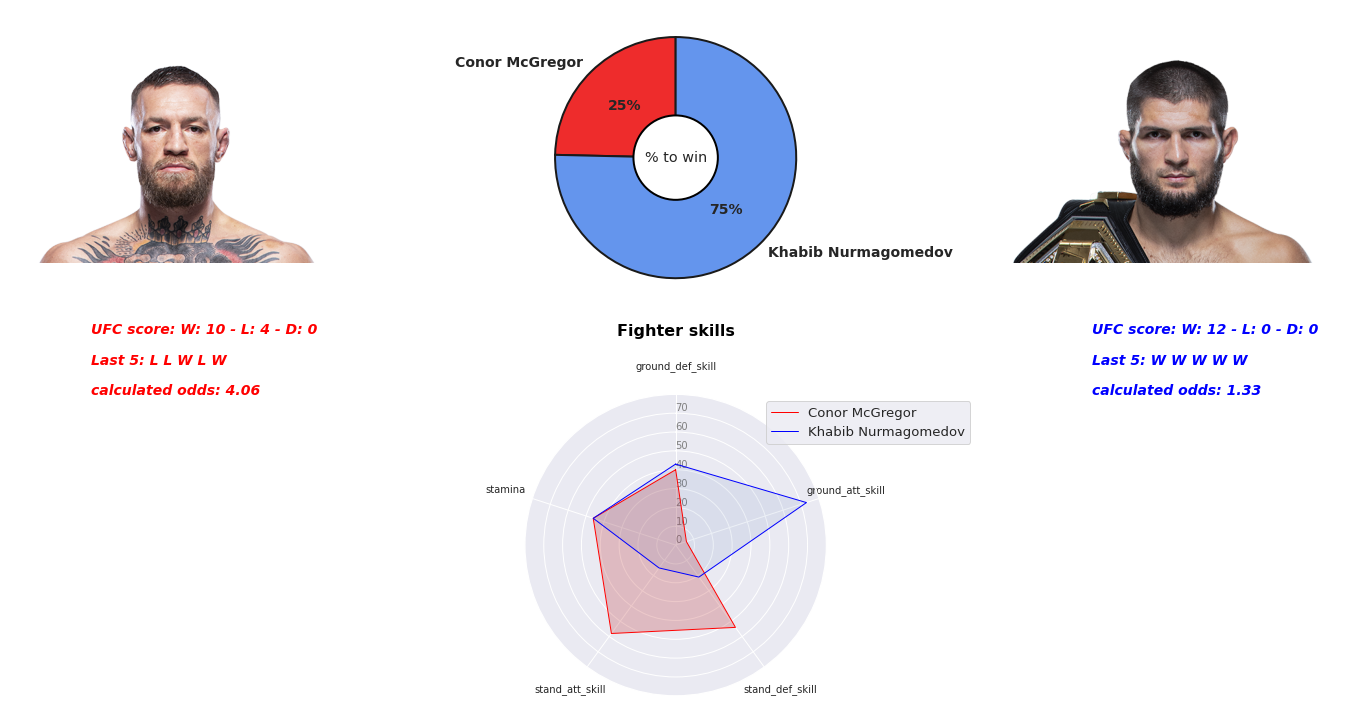

In [61]:
Head2Head('Conor McGregor','Khabib Nurmagomedov')

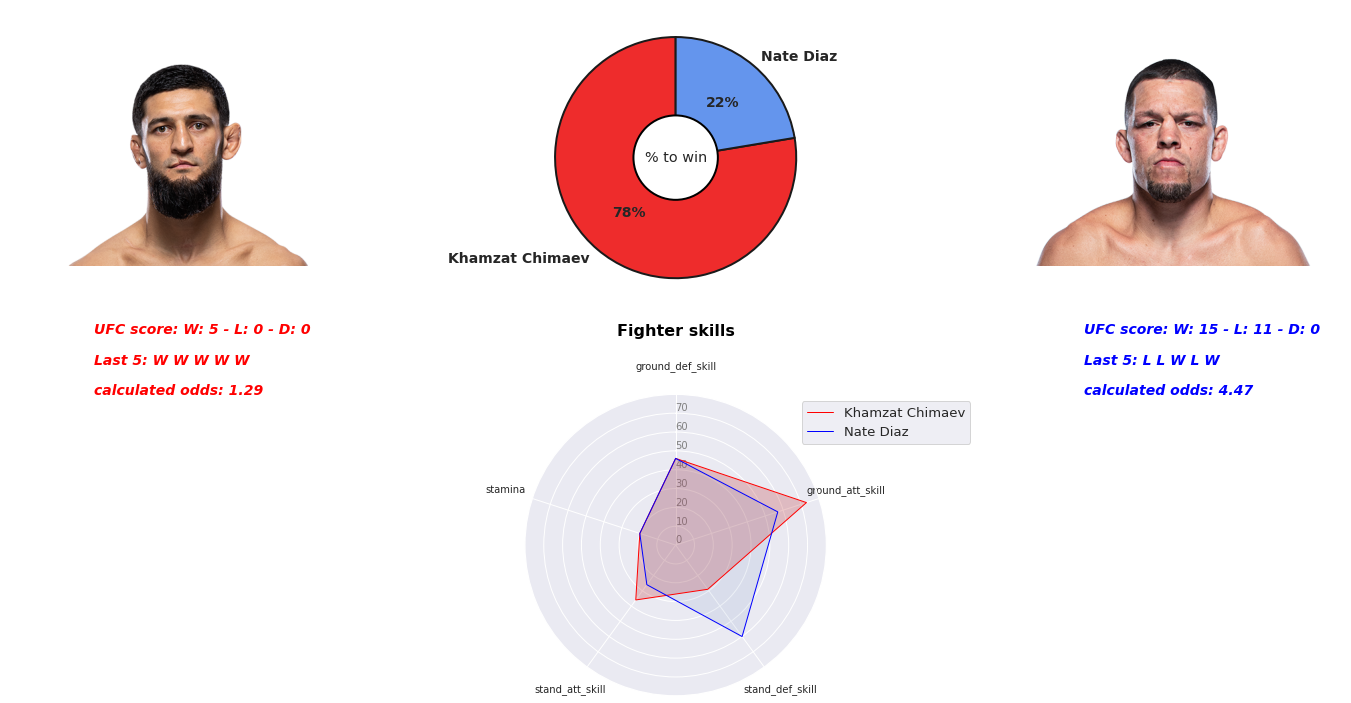

In [62]:
Head2Head('Khamzat Chimaev','Nate Diaz')

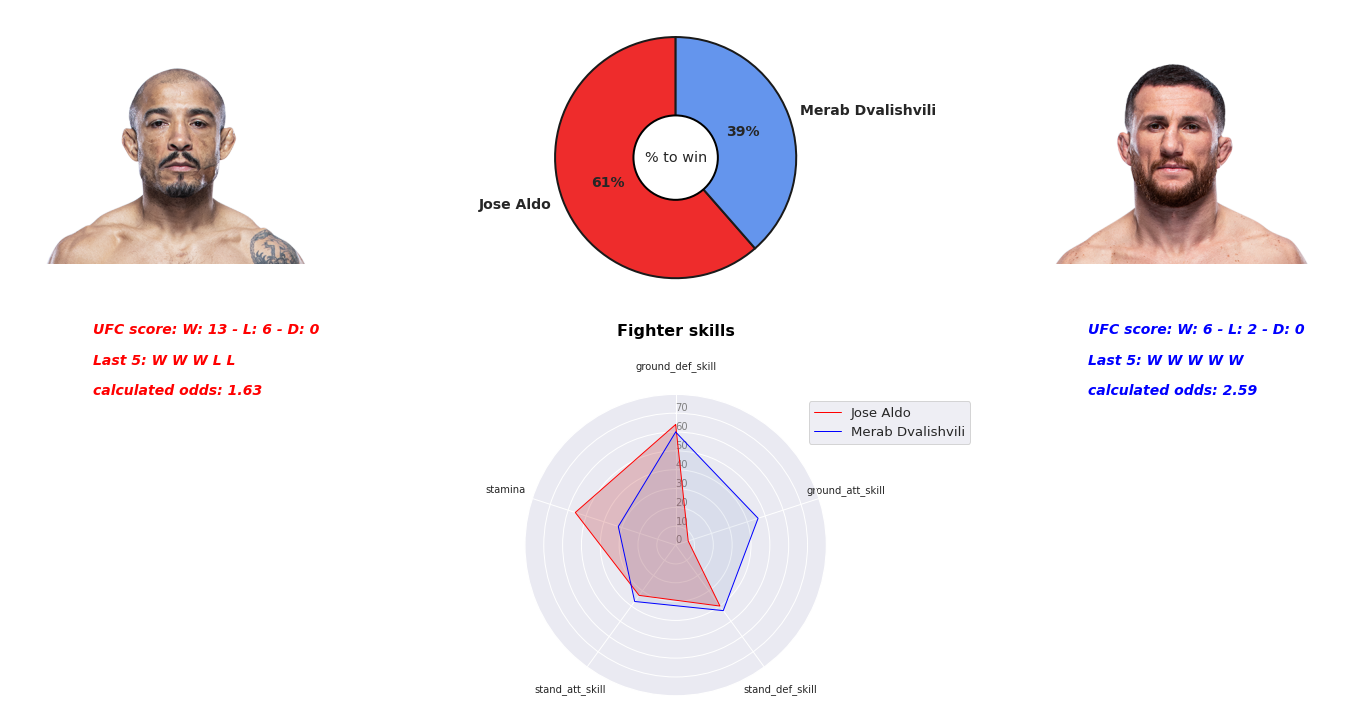

In [63]:
Head2Head('Jose Aldo','Merab Dvalishvili')

**Thanks for visiting my notebook. Please upvote if you like. I will appreciate for any feedback :)**